## Notebook Setup

In [1]:
# importing standard libraries
import tensorflow as tf
print(tf.__version__)
import matplotlib.pylab as plt
import numpy as np

# Importing utils and models
import sys
sys.path.append('../')
from utils import process_path, tf_dataset_generator, get_class_weights
from models import EnetEncoder

2.0.0


## Create training test and validation dataset, and get class weights

In [2]:
# creating datasets
train_path = '../dataset/train/images'
val_path = '../dataset/val/images'
test_path = '../dataset/test/images'
train_ds = tf_dataset_generator(train_path)
val_ds = tf_dataset_generator(val_path,train=False,cache=False)
test_ds = tf_dataset_generator(test_path,train=False,cache=False)

# get class weights
class_weights = get_class_weights(tf_dataset_generator(train_path,train=False,cache=False))

Tensor("args_0:0", shape=(), dtype=string) Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string) Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string) Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string) Tensor("StaticRegexReplace:0", shape=(), dtype=string)


In [3]:
class_weights

array([ 5.79203481,  4.44028773, 34.02166463,  3.44690044, 15.91194352,
        9.02023585, 32.01377376, 32.47892445, 13.20714089, 38.38765298,
       44.13450551, 17.30636391])

## Example (Image,Label) pair from the validation set

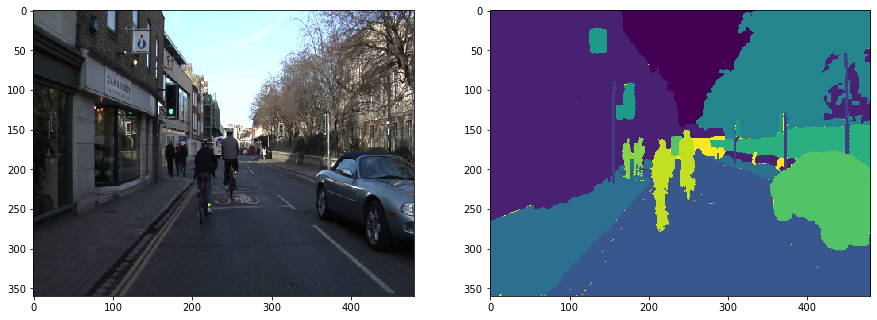

In [4]:
for img,iml in val_ds.take(1):
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(iml.numpy()[:,:,0])

In [5]:
for img,iml in train_ds.take(1):
    img_test = img
    iml_test = iml

## Create the model

In [6]:
Enet = EnetEncoder(C=12)

In [31]:
# compile model
Enet.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Fit model

In [ ]:
Enet.fit(x= train_ds,
         epochs=10,
         validation_data=val_ds,
         class_weight=class_weights,
         steps_per_epoch=367//32,
         validation_steps=101//32//5)

Train for 11 steps
Epoch 1/10
 1/11 [=>............................] - ETA: 0s